Useless for now since all the simulations converged

In [1]:
import os
import re
import numpy as np
import pandas as pd
import json
from pathlib import Path
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import xgboost as xgb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def load_json(filepath: str):
    with open(filepath) as file:
        data = json.load(file)
    return data

In [3]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)

PERIODIC_TABLE_PATH = os.path.join(
    os.path.dirname(os.getcwd()), "data_preprocessing/periodic_table_info.json",
)
PERIODIC_TABLE_INFO = load_json(PERIODIC_TABLE_PATH)

# Loading Data

In [4]:
def parse_structure_files(data_path, encoding):
    structure_files = []
    p = Path(data_path)
    for struct_dir in p.iterdir():
        if not struct_dir.is_dir():
            continue
        for file in struct_dir.glob(f"*{encoding}*.csv"):
            structure_name = os.path.basename(struct_dir)

            # Parsing the structure name to get the elements and their number
            elts = re.findall("[A-Z][^A-Z]*", structure_name)
            elements_nbrs = defaultdict(int)
            for elt in elts:
                atom_num = re.findall("\d+|\D+", elt)
                if len(atom_num) == 1:
                    elements_nbrs[elt] += 1
                else:
                    elements_nbrs[elt[0]] += int(elt[1])

            # Skip Lantanides
            isLant = False
            for elt in elements_nbrs.keys():
                if PERIODIC_TABLE_INFO[elt]["PTC"] == "Lant":
                    isLant = True
            if not isLant:
                structure_files.append(file)
            
    return structure_files

In [5]:
# structure_names = ["Ge-1_Se-1", "Ge-1_Te-1", "Ge-1_Sb-1", "Si-1_C-1"]
encoding = "column_mass"
structure_files = parse_structure_files(DATA_DIR, encoding)

In [6]:
df = pd.concat([pd.read_csv(filepath, index_col=0) for filepath in structure_files], ignore_index=True)

In [7]:
cols_raw = list(df.columns)
cols_trash = ['delta_E', 'accuracy', "n_iterations", "time", "fermi", "total_energy"]
cols_independent = ['converged']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [8]:
X_raw = df[cols_dependent]
y_raw = np.abs(df[cols_independent]).squeeze()

In [9]:
X_raw.describe()

,ecutrho,k_density,ecutwfc,PTC1,PTC2,PTC3,PTC4,PTC5,PTC6,PTC7,...,PTC9,PTC10,PTC11,PTC12,PTC13,PTC14,PTC15,PTC16,PTC17,PTC18
count,9685.000000,9685.000000,9685.000000,9685.000000,9685.000000,9685.0,9685.0,9685.000000,9685.000000,9685.000000,...,9685.000000,9685.000000,9685.000000,9685.000000,9685.000000,9685.000000,9685.000000,9685.000000,9685.000000,9685.0
mean,244.553433,5.934744,57.680434,0.035225,0.112689,0.0,0.0,0.004630,0.040728,0.044393,...,0.112296,0.034506,0.017553,0.034571,0.044590,0.188340,0.129818,0.106643,0.052808,0.0
std,89.263123,2.827090,23.852574,0.143701,0.296666,0.0,0.0,0.046771,0.109673,0.152593,...,0.291421,0.128974,0.131326,0.148335,0.197012,0.291321,0.215191,0.202923,0.180655,0.0
min,100.000000,2.000000,20.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,180.000000,4.000000,35.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,260.000000,6.000000,55.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,340.000000,8.000000,75.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.373663,0.279351,0.000000,0.000000,0.0
max,380.000000,10.000000,100.000000,0.621404,1.000000,0.0,0.0,0.477041,0.339697,0.796842,...,1.000000,0.516524,1.000000,0.670976,0.914951,1.000000,0.626337,0.637235,0.720649,0.0


# Train-Test-Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    random_state=42
)

# Model definitions

### Random forest

In [11]:
rf_model = RandomForestClassifier(random_state=0)

### Gradient Boosting

In [12]:
gb_model = GradientBoostingClassifier(n_estimators=5000, learning_rate=0.05, random_state=0)

### XGBoost

In [13]:
xgb_model = xgb.XGBClassifier(n_estimators=5000, learning_rate=0.05, random_state=0)

### Packing them together to reduce code size

In [14]:
models = {
    "Random Forest": rf_model,
    # "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
}

# Model training

In [15]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print("Done!\n")

Training Random Forest...
Done!

Training XGBoost...
Done!



# Model evaluation

In [16]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # classification accuracy
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    # f1 score
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)

    print(f"Accuracy:\ttrain:{train_acc}\ttest:{test_acc}")
    print(f"F1 score:\ttrain:{train_f1}\ttest:{test_f1}")

    print("Done!\n")

Evaluating Random Forest...
Accuracy:	train:1.0	test:1.0
F1 score:	train:1.0	test:1.0
Done!

Evaluating XGBoost...
Accuracy:	train:1.0	test:1.0
F1 score:	train:1.0	test:1.0
Done!



# Visualization

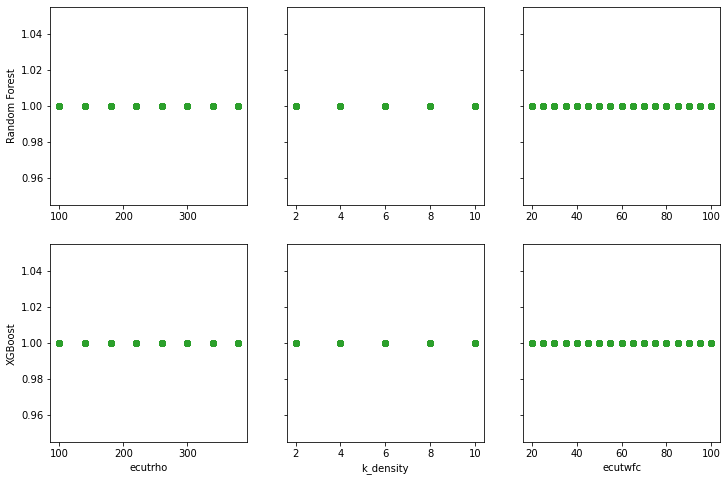

In [17]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')
PLOTPATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "plots/delta_E_regression/toy_comparison.png")
plt.savefig(PLOTPATH)

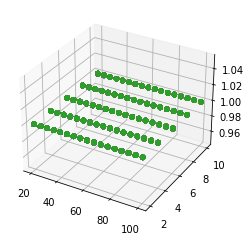

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['ecutwfc'], X_train['k_density'], y_train)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], y_test)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], rf_model.predict(X_test))